#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

iris = load_iris()

x = iris.data
y = iris.target


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=123
)
# print(y_train[x_train[:, 2] <= 5])

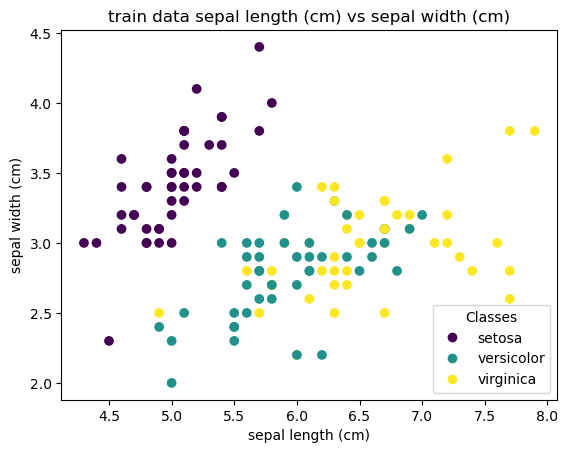

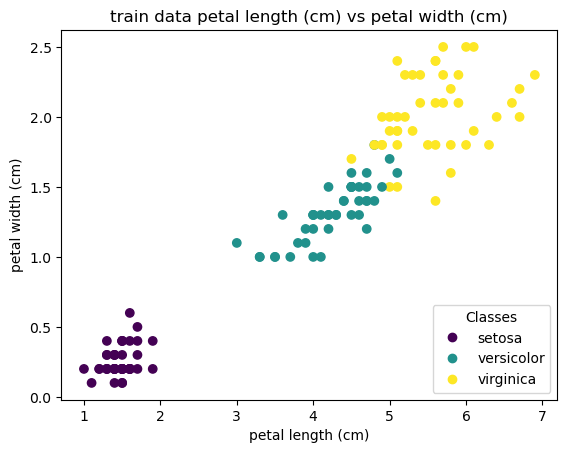

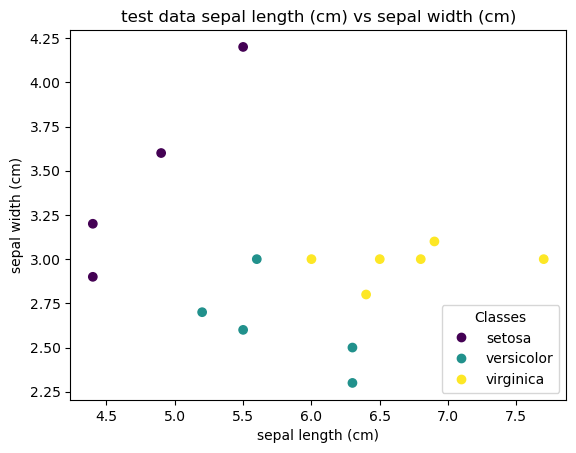

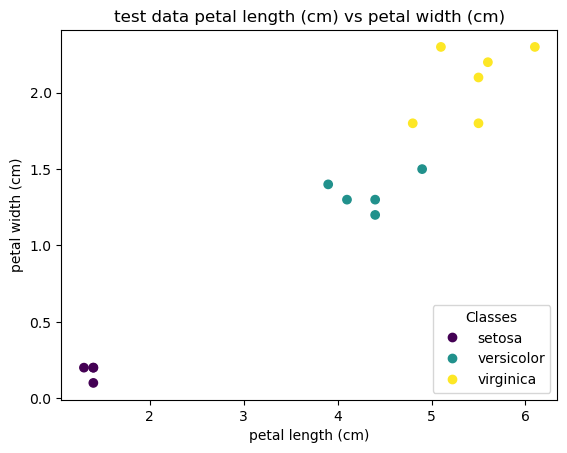

In [3]:
for key, data in {"train": [x_train, y_train], "test": [x_test, y_test]}.items():
    for features in [[0, 1], [2, 3]]:
        _, ax = plt.subplots()
        scatter = ax.scatter(
            data[0][:, features[0]], data[0][:, features[1]], c=data[1]
        )
        ax.set(
            xlabel=iris.feature_names[features[0]],
            ylabel=iris.feature_names[features[1]],
        )
        _ = ax.legend(
            scatter.legend_elements()[0],
            iris.target_names,
            loc="lower right",
            title="Classes",
        )
        ax.set_title(
            f"{key} data {iris.feature_names[features[0]]} vs {iris.feature_names[features[1]]}"
        )



In [17]:
def entropy_func(class_count, num_samples):
    return -class_count / num_samples * math.log(class_count / num_samples, 2)


class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return self.group_classes.size

    def group_entropy(self):
        return sum(entropy_func(Counter(self.group_classes)[class_val], 
                                len(self.group_classes)) 
                   for class_val in np.unique(self.group_classes))


class Node:
    def __init__(
        self,
        split_feature,
        split_val,
        depth=None,
        child_node_a=None,
        child_node_b=None,
        val=None,
    ):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data):
        if self.val is not None:
            return self.val
        if data[self.split_feature] <= self.split_val:
            return self.child_node_a.predict(data)
        else:
            return self.child_node_b.predict(data)


class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a, group_b):
        return sum(
            group.entropy * (len(group) / (len(group_a) + len(group_b)))
            for group in [group_a, group_b]
        )

    def get_split_values(self, feature_values):
        sorted_feature_values = np.sort(feature_values)
        return [
            np.mean([sorted_feature_values[i], sorted_feature_values[i + 1]])
            for i in range(len(sorted_feature_values) - 1)
        ]

    def get_information_gain(self, parent_group, child_group_a, child_group_b):
        split_entropy = DecisionTreeClassifier.get_split_entropy(child_group_a, child_group_b)
        return parent_group.entropy - split_entropy

    def get_best_feature_split(self, feature_values, classes):
        max_information_gain, best_feature_split = 0, None
        split_values = self.get_split_values(feature_values)
        for val in split_values:
            group_a = Group(classes[feature_values <= val])
            group_b = Group(classes[feature_values > val])
            information_gain = self.get_information_gain(
                Group(classes), group_a, group_b
            )
            if information_gain > max_information_gain:
                max_information_gain = information_gain
                best_feature_split = val
        return best_feature_split, max_information_gain

    def get_best_split(self, data, classes):
        max_information_gain, max_feature, best_split_val = 0, None, None
        for feature in range(data.shape[1]):
            split_val, information_gain = self.get_best_feature_split(data[:, feature], classes)
            if information_gain > max_information_gain:
                max_information_gain = information_gain
                max_feature = feature
                best_split_val = split_val
        return max_feature, best_split_val

    def build_node(self, data, classes, depth):
        if len(np.unique(classes)) == 1 or depth == self.max_depth:
            val = Counter(classes).most_common(1)[0][0]
            return Node(None, None, depth, val=val)
        split_feature, split_val = self.get_best_split(data, classes)
        indeces_a = data[:, split_feature] <= split_val
        indeces_b = data[:, split_feature] > split_val
        if len(indeces_a) == 0 or len(indeces_b) == 0:
            val = Counter(classes).most_common(1)[0][0]
            return Node(None, None, depth, val=val)
        children_nodes = []
        for indeces in [indeces_a, indeces_b]:
            child_data = data[indeces]
            child_classes = classes[indeces]
            children_nodes.append(self.build_node(child_data, child_classes, depth + 1))
        return Node(
            split_feature,
            split_val,
            depth,
            children_nodes[0],
            children_nodes[1],
        )

    def build_tree(self, data, classes):
        depth = self.depth
        self.tree = self.build_node(data, classes, depth)

    def predict(self, data):
        return self.tree.predict(data)

In [19]:
dc = DecisionTreeClassifier(3)
correct = 0
dc.build_tree(x_train, y_train) 
for sample, target in zip(x_test, y_test):
    prediction = dc.predict(sample)
    if prediction == target:
        correct += 1
    print("Prediction: " + str(prediction) + " Target: " + str(target))
print("\nCorrect: " + str(correct))   
print("Num of test samples: " + str(len(x_test)))
print("Accuracy: " + str(correct / len(x_test)))

Prediction: 2 Target: 1
Prediction: 2 Target: 2
Prediction: 2 Target: 2
Prediction: 1 Target: 1
Prediction: 0 Target: 0
Prediction: 2 Target: 2
Prediction: 1 Target: 1
Prediction: 0 Target: 0
Prediction: 0 Target: 0
Prediction: 1 Target: 1
Prediction: 2 Target: 2
Prediction: 0 Target: 0
Prediction: 1 Target: 1
Prediction: 2 Target: 2
Prediction: 2 Target: 2

Correct: 14
Num of test samples: 15
Accuracy: 0.9333333333333333


### Eksperymenty - Różna głębokość drzewa i różne wielkości zbioru testowego

In [67]:
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.9]
depth_list = [1, 2, 3, 4, 5, 6, 7]
accuracy_array = np.array([])
precision_array = np.array([])
iterations = 10


for test_size in test_sizes:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size
    )
    ts_acc_array = np.array([])

    for depth in depth_list:
        
        dc = DecisionTreeClassifier(depth)
        correct = 0
        dc.build_tree(x_train, y_train)
        for sample, target in zip(x_test, y_test):
            prediction = dc.predict(sample)
            if prediction == target:
                correct += 1
        accuracy = correct / len(x_test)
        ts_acc_array = np.append(ts_acc_array, accuracy)
    if accuracy_array.size == 0:
        accuracy_array = ts_acc_array
    else:
        accuracy_array = np.vstack([accuracy_array, ts_acc_array])

test_sizes_df = pd.DataFrame(accuracy_array, index=test_sizes, columns=depth_list)


In [66]:
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.9]
depth_list = [1, 2, 3, 4, 5, 6, 7]
accuracy_array = np.array([])
precision_array = np.array([])
iterations = 10

for depth in depth_list:
    ts_acc_array = np.array([])
    for test_size in test_sizes:
        ts_d_array = []
        for i in range(iterations):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
            dc = DecisionTreeClassifier(depth)
            correct = 0
            dc.build_tree(x_train, y_train)
            for sample, target in zip(x_test, y_test):
                prediction = dc.predict(sample)
                if prediction == target:
                    correct += 1
                
            accuracy = correct / len(x_test)

            ts_d_array.append(accuracy)
        accuracy_mean = np.mean(ts_d_array)
        ts_acc_array = np.append(ts_acc_array, accuracy_mean)
    if accuracy_array.size == 0:
        accuracy_array = ts_acc_array
    else:
        accuracy_array = np.vstack([accuracy_array, ts_acc_array])

test_sizes_df = pd.DataFrame(accuracy_array, index=depth_list, columns=test_sizes)

In [56]:
test_sizes_df.style.format(precision=3, thousands=".", decimal=",").highlight_max(color="darkblue", axis=0)

,0.100000,0.200000,0.300000,0.400000,0.900000
1,"0,600","0,600","0,611","0,625","0,599"
2,"0,933","0,923","0,929","0,938","0,854"
3,"0,973","0,933","0,933","0,950","0,853"
4,"0,933","0,937","0,933","0,945","0,789"
5,"0,927","0,930","0,947","0,947","0,788"
6,"0,907","0,930","0,927","0,923","0,839"
7,"0,960","0,923","0,929","0,932","0,827"


Tabelka przedstawiająca zależność między dokłądnością, wielkością zbioru testowego (wiersze) i głębokością drzewa (kolumny). Na niebiesko zostałyzaznaczone największe wartości w wierszach.

Text(0.5, 1.0, 'Zależność dokładności klasyfikacji od głębokości drzewa i wielkości zbioru testowego')

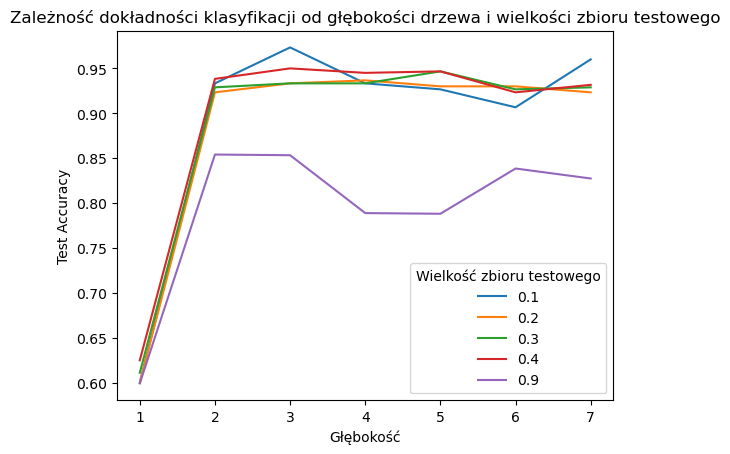

In [64]:
_, ax = plt.subplots()
# for i in range(len(test_sizes)):
for i in range(len(test_sizes)):
    plot = ax.plot(
        depth_list, accuracy_array[:, i]
    )
ax.set(
    xlabel="Głębokość",
    ylabel="Test Accuracy",
)
ax.legend(
    test_sizes,
    loc="lower right",
    title="Wielkość zbioru testowego",
)
ax.set_title(
    "Zależność dokładności klasyfikacji od głębokości drzewa i wielkości zbioru testowego"
)

Dokładność klasyfikacji rośnie wraz ze zwiększaniem głębokości drzewa. Dokładność rośnie do głębokości **depth = 3**. Dla głębokości większych dokłądność nieco maleje, następnie pozostaje stała. Wynika to z nadmiernego dopasowania modelu do danych trenujących. Dalsze zwiększanie głębokości nie wpływa na wynik.

Zwiększenie zbioru testowego względem trenującego pogarsza wyniki. Pomniejszenie zbioru uczącego powoduje zmniejszenie dokładności na zbiorze testowym. 


### Porównanie dokładności na danych trenujących vs testujących

In [30]:
test_sizes = [0.1, 0.15, 0.2, 0.3]
depth_list = [2, 3, 4, 5, 6, 7]

for test_size in test_sizes:
    accuracy_array = np.array([])
    train_accuracy_array = np.array([])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    for depth in depth_list:
        depth_accuracy = np.array([])
        dc = DecisionTreeClassifier(depth)
        correct = 0
        train_correct = 0
        dc.build_tree(x_train, y_train)
        for sample, target in zip(x_train, y_train):
            prediction = dc.predict(sample)
            if prediction == target:
                train_correct += 1
        train_accuracy = train_correct / len(x_train)

        for sample, target in zip(x_test, y_test):
            prediction = dc.predict(sample)
            if prediction == target:
                correct += 1
        accuracy = correct / len(x_test)
        
        accuracy_diff = train_accuracy - accuracy
        depth_accuracy = np.append(depth_accuracy, train_accuracy)
        depth_accuracy = np.append(depth_accuracy, accuracy)
        depth_accuracy = np.append(depth_accuracy, accuracy_diff)
        if accuracy_array.size == 0:
            accuracy_array = depth_accuracy
        else:
            accuracy_array = np.vstack([accuracy_array, depth_accuracy])
    print(f"Test size: {test_size}")

    df = pd.DataFrame(
        accuracy_array, index=depth_list, columns=["train accuracy", "test accuracy", "accuracy difference"]
    )
    df = df.style.format(precision=3, thousands=".", decimal=",").highlight_max(
        color="darkblue"
    )
    display(df)

Test size: 0.1


,train accuracy,test accuracy,accuracy difference
2,"0,963","0,933","0,030"
3,"0,985","0,933","0,052"
4,"0,993","0,933","0,059"
5,"1,000","0,933","0,067"
6,"1,000","0,933","0,067"
7,"1,000","0,933","0,067"


Test size: 0.15


,train accuracy,test accuracy,accuracy difference
2,"0,961","0,957","0,004"
3,"0,969","0,957","0,012"
4,"1,000","0,957","0,043"
5,"1,000","0,957","0,043"
6,"1,000","0,957","0,043"
7,"1,000","0,957","0,043"


Test size: 0.2


,train accuracy,test accuracy,accuracy difference
2,"0,967","0,933","0,033"
3,"0,983","0,967","0,017"
4,"1,000","0,933","0,067"
5,"1,000","0,933","0,067"
6,"1,000","0,933","0,067"
7,"1,000","0,933","0,067"


Test size: 0.3


,train accuracy,test accuracy,accuracy difference
2,"0,971","0,911","0,060"
3,"0,981","0,933","0,048"
4,"1,000","0,933","0,067"
5,"1,000","0,933","0,067"
6,"1,000","0,933","0,067"
7,"1,000","0,933","0,067"


In [65]:
test_sizes = [0.1, 0.15, 0.2, 0.3]
depth_list = [2, 3, 4, 5, 6, 7]

for test_size in test_sizes:
    accuracy_array = np.array([])
    train_accuracy_array = np.array([])
    for depth in depth_list:
        accuracy_diff_array = []
        accuracy_train_array = []
        accuracy_test_array = []
        for i in range(iterations):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
            depth_accuracy = np.array([])
            dc = DecisionTreeClassifier(depth)
            correct = 0
            train_correct = 0
            dc.build_tree(x_train, y_train)
            for sample, target in zip(x_train, y_train):
                prediction = dc.predict(sample)
                if prediction == target:
                    train_correct += 1
            train_accuracy = train_correct / len(x_train)

            for sample, target in zip(x_test, y_test):
                prediction = dc.predict(sample)
                if prediction == target:
                    correct += 1
            accuracy = correct / len(x_test)
            accuracy_diff = train_accuracy - accuracy
            
            accuracy_diff_array.append(accuracy_diff)
            accuracy_train_array.append(train_accuracy)
            accuracy_test_array.append(accuracy)
        accuracuy = np.mean(accuracy_test_array)
        train_accuracy = np.mean(accuracy_train_array)
        accuracy_diff = np.mean(accuracy_diff_array)
        
        depth_accuracy = np.append(depth_accuracy, train_accuracy)
        depth_accuracy = np.append(depth_accuracy, accuracy)
        depth_accuracy = np.append(depth_accuracy, accuracy_diff)
        if accuracy_array.size == 0:
            accuracy_array = depth_accuracy
        else:
            accuracy_array = np.vstack([accuracy_array, depth_accuracy])
    print(f"Test size: {test_size}")

    df = pd.DataFrame(
        accuracy_array,
        index=depth_list,
        columns=["train accuracy", "test accuracy", "accuracy difference"],
    )
    df = df.style.format(precision=3, thousands=".", decimal=",").highlight_max(
        color="darkblue"
    )
    display(df)

Test size: 0.1


,train accuracy,test accuracy,accuracy difference
2,"0,963","0,867","0,036"
3,"0,977","0,867","0,037"
4,"0,996","0,933","0,056"
5,"0,998","0,933","0,064"
6,"1,000","0,933","0,060"
7,"1,000","1,000","0,053"


Test size: 0.15


,train accuracy,test accuracy,accuracy difference
2,"0,963","0,913","0,020"
3,"0,971","0,957","0,006"
4,"0,996","0,913","0,057"
5,"0,998","0,957","0,046"
6,"1,000","0,870","0,065"
7,"1,000","1,000","0,061"


Test size: 0.2


,train accuracy,test accuracy,accuracy difference
2,"0,964","0,900","0,041"
3,"0,976","0,967","0,022"
4,"0,990","0,900","0,040"
5,"0,998","0,933","0,082"
6,"1,000","0,900","0,077"
7,"1,000","0,800","0,087"


Test size: 0.3


,train accuracy,test accuracy,accuracy difference
2,"0,964","0,867","0,022"
3,"0,978","0,956","0,043"
4,"0,991","0,911","0,054"
5,"0,994","0,956","0,063"
6,"0,999","0,933","0,106"
7,"0,999","0,911","0,077"


W powyższych taebelkach na niebiesko zostały oznaczone największe wartości z kolumny. 

Zwiększanie głębokości drzewa powoduje zwiększenie dokłądności modelu, aż do momentu w którym model nadmiernie dopasowuje się do danych trenujących. 

W powyższych przykłądach, dla większosci proporcji danych testujących, najlepsza dokłądność została osiągnieta dla głębokości 3. Dla większych głebokości dokładność na danych testowych zaczęła maleć. Dokładność dla danych testowych  oraz różnica między dwoma dokłądnościami zaczęły rosnąć.